In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = '/content/drive/MyDrive/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


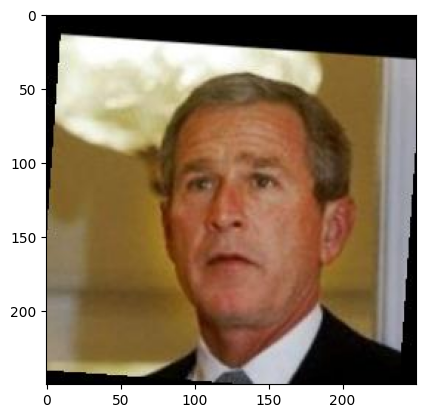

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Autoencoders (AEs) and Variational Autoencoders (VAEs) are both types of neural network architectures used for learning efficient data codings in an unsupervised manner. Despite their similar names, they have different applications, architectures, and loss functions.

### Applications

**AutoEncoders:**
- **Dimensionality Reduction**: AEs are often used for reducing the dimensionality of data, similar to PCA but with a non-linear approach.
- **Feature Learning**: They can learn to capture the main features of the data, which can be useful in pre-training for other tasks.
- **Noise Reduction**: AEs can be used in denoising, where they learn to remove noise from data.

**Variational AutoEncoders:**
- **Generative Modeling**: VAEs are widely used in generative tasks where the goal is to generate new data samples that are similar to the training data.
- **Data Imputation**: They can be used to fill in missing data or reconstruct incomplete data.
- **Anomaly Detection**: VAEs can be used to detect anomalies by examining the reconstruction error and latent space distributions.

### Architecture

**AutoEncoders:**
- AEs consist of two main parts: an encoder and a decoder. The encoder compresses the input into a lower-dimensional latent space, and the decoder reconstructs the input from this latent representation.
- The architecture is deterministic, meaning the same input will always produce the same encoded representation.

**Variational AutoEncoders:**
- VAEs also have an encoder and a decoder. However, the encoder in a VAE outputs a distribution (typically Gaussian) over the latent space instead of a fixed point.
- VAE introduces a stochastic element in the encoding process, where the encoder generates parameters of a probability distribution (mean and variance) from which the latent representation is sampled.

### Loss Function

**AutoEncoders:**
- The loss function in AEs is typically the reconstruction loss, which measures the difference between the input and its reconstruction. Common choices are mean squared error or binary cross-entropy.

**Variational AutoEncoders:**
- VAEs have a more complex loss function, which is a combination of two terms: the reconstruction loss (like in AEs) and the KL divergence.
- The KL divergence is a regularizer that measures how much the learned distribution in the latent space diverges from a prior distribution (usually a standard Gaussian). This term ensures that the latent space has good properties (like continuity and completeness) which are crucial for generative tasks.

In summary, while both AEs and VAEs use encoder-decoder architectures for learning efficient data representations, VAEs introduce a probabilistic approach and are more suited for generative tasks due to their loss function which balances reconstruction accuracy with latent space regularization.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        # Reparameterization within the encoder
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, log_var

    def decoder(self, z):
        h = F.relu(self.fc2(z))
        reconstruction = torch.sigmoid(self.fc3(h))
        return reconstruction

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), mu, log_var


In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.5)  # Adding dropout layer
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.5)  # Adding dropout layer
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = self.dropout1(h)  # Apply dropout
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        # Reparameterization within the encoder
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, log_var

    def decoder(self, z):
        h = F.relu(self.fc2(z))
        h = self.dropout2(h)
        reconstruction = torch.sigmoid(self.fc3(h))
        return reconstruction

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), mu, log_var


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [9]:
import torch
# 1. Create an instance of your VAE model
input_dim = 784  # Replace with your input dimension
hidden_dim = 400  # Replace with your hidden dimension
latent_dim = 20  # Replace with your latent dimension

model = VAE(input_dim, hidden_dim, latent_dim)

# Update these values according to your actual image dimensions
image_width = 250
image_height = 250
num_channels = 3  # 3 for RGB, 1 for grayscale

# The flattened size of each image
flattened_size = image_width * image_height * num_channels

# Update your VAE class initialization
model = VAE(flattened_size, hidden_dim, latent_dim)

# Move the model to the appropriate device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 64

for batch in dataloader:
    images = batch[0].to(device)

    # Normalize images to [0, 1]
    images = images / 255.0  # Assuming your images are in the 0-255 range

    # Check the shape of your images
    print("Original image shape:", images.shape)

    # Flatten the images
    # This reshapes images from [batch_size, C, H, W] to [batch_size, C*H*W]
    images = images.view(images.size(0), -1)
    print("Flattened image shape:", images.shape)

    # Pass the images through the encoder
    z, mu, log_var = model.encoder(images)

    # 3. Print the shape of the encoder's output
    print("Shape of z (latent space representation):", z.shape)
    print("Shape of mu (mean):", mu.shape)
    print("Shape of log_var (log variance):", log_var.shape)

    # 4. Use the decoder to create new images
    reconstructed_images = model.decoder(z)

    # 5. Print the shape of the output
    print("Shape of reconstructed images:", reconstructed_images.shape)

    # Additional step: Verify the forward pass
    # (Feed the images through the entire model and check output shape)
    output_images, _, _ = model(images)
    print("Shape of output images from full model:", output_images.shape)

    # Break after the first batch for demonstration
    break


Original image shape: torch.Size([32, 3, 250, 250])
Flattened image shape: torch.Size([32, 187500])
Shape of z (latent space representation): torch.Size([32, 20])
Shape of mu (mean): torch.Size([32, 20])
Shape of log_var (log variance): torch.Size([32, 20])
Shape of reconstructed images: torch.Size([32, 187500])
Shape of output images from full model: torch.Size([32, 187500])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [10]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the model:", total_params)

Total number of parameters in the model: 150212340


In [12]:
def vae_loss(reconstructed_x, x, mu, log_var):
    # Reconstruction loss (MSE or Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum') / x.size(0)

    # KL divergence, scaled by batch size
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)

    return recon_loss + kl_loss


In a Variational AutoEncoder (VAE), the loss function plays a crucial role in learning both the distribution of the input data and how to reconstruct it. The VAE loss function typically consists of two main components: the reconstruction loss and the Kullback-Leibler (KL) divergence. Let's break down these components and their purposes:

1. **Reconstruction Loss**:
   - **Purpose**: This part of the loss function measures how well the VAE can reconstruct the input data. The goal is to minimize the difference between the original input and its reconstructed output, thereby ensuring that the VAE learns a meaningful representation of the data.
   - **Implementation**: Common choices for the reconstruction loss are Mean Squared Error (MSE) for continuous data or Binary Cross-Entropy (BCE) for binary or normalized data. MSE measures the average of the squares of the differences between actual and reconstructed values, suitable for input data with a wide range of values. In contrast, BCE is used when the input data is in the form of probabilities or binary values (e.g., pixel values in an image normalized to the range [0, 1]).

2. **Kullback-Leibler (KL) Divergence**:
   - **Purpose**: The KL divergence acts as a regularizer in the VAE loss function. It measures how much the distribution of the latent variables (as learned by the encoder) diverges from a prior distribution, which is typically assumed to be a standard normal distribution. This regularization encourages the latent space to adhere to a known distribution (normal distribution), which is crucial for the generative aspect of VAEs.
   - **Implementation**: The KL divergence is calculated between the learned distribution (defined by the mean and log variance output by the encoder) and the standard normal distribution. It ensures that the latent space is continuous and complete, meaning that points close to each other in the latent space result in similar outputs, and any point sampled from the latent space can decode into a valid output.

### Overall Goal of the Loss Function:

- The reconstruction loss ensures that the VAE can accurately reconstruct the input data, thereby learning a compressed representation of the data in the latent space.
- The KL divergence ensures that the latent space has good properties for generative tasks. It prevents the model from encoding input data in an arbitrary manner, thereby enabling it to generate new data samples that are similar to the original dataset.

In essence, the VAE loss function balances the model's ability to reconstruct the input data accurately (through the reconstruction loss) and to learn a latent space that is well-structured for data generation (through the KL divergence). This balance is key to the effectiveness of VAEs as both generative models and tools for unsupervised learning of data representations.

* create an optimizer for training

In [11]:
import torch.optim as optim

# Set the learning rate
learning_rate = 0.005

# Create the optimizer
optimi = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
#loss_function =F.binary_cross_entropy(reconstructed_images[0], images[0], reduction='sum') - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [14]:
num_epochs = 10 # You can adjust this based on your requirement
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        images = batch[0].to(device)

        # Normalize and flatten images
        images = images / 255.0
        images = images.view(images.size(0), -1)

        # Reset gradients
        optimi.zero_grad()

        # Forward pass
        reconstructed_images, mu, log_var = model(images)

        # Debugging: Check the range of reconstructed_images
        #print("Min value:", reconstructed_images.min().item(), "Max value:", reconstructed_images.max().item())

        # Compute loss
        loss = vae_loss(reconstructed_images, images, mu, log_var)

        # Backward pass and optimize
        loss.backward()
        optimi.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/10], Loss: 101.0880
Epoch [2/10], Loss: 65.0171
Epoch [3/10], Loss: 64.5719
Epoch [4/10], Loss: 64.3736
Epoch [5/10], Loss: 64.2677
Epoch [6/10], Loss: 64.1870
Epoch [7/10], Loss: 64.1041
Epoch [8/10], Loss: 64.0575
Epoch [9/10], Loss: 64.0480
Epoch [10/10], Loss: 64.0039


If the loss in your Variational AutoEncoder (VAE) isn't decreasing as expected during training, it indicates that the model isn't learning effectively. There are several strategies you can employ to troubleshoot and resolve this issue:

1. **Check Data Preprocessing**:
   - Ensure that your data is correctly preprocessed. For images, this often includes normalization (e.g., scaling pixel values to the range [0, 1] or [-1, 1]) and ensuring the data is in the correct format (e.g., flattened if required by the model).

2. **Adjust Learning Rate**:
   - If the learning rate is too high, the model might skip over minima; if it's too low, the training might progress very slowly. Experiment with different learning rates.

3. **Inspect the Loss Function**:
   - Ensure that the loss function is implemented correctly, particularly the balance between reconstruction loss and KL divergence. Incorrect implementation or weighting might hinder learning.

4. **Modify Model Architecture**:
   - Experiment with the model's architecture. This can include changing the number of layers, the number of neurons in each layer, or the types of layers (e.g., adding or removing dropout layers).

5. **Batch Size**:
   - Adjust the batch size. Sometimes smaller or larger batch sizes can have a significant impact on model training.

6. **Regularization Techniques**:
   - Implement or adjust regularization methods like dropout or weight decay to prevent overfitting, which can affect the model's ability to generalize.

7. **Gradient Clipping**:
   - Use gradient clipping to prevent issues with exploding gradients, which can cause instability in training.

8. **Early Stopping**:
   - Implement early stopping to prevent overfitting. This technique stops training when the validation loss stops improving.

9. **Examine Training Dynamics**:
   - Analyze the learning curves for both training and validation loss. If the validation loss begins to increase while the training loss decreases, it might indicate overfitting.

10. **Data Augmentation**:
    - If you're working with image data, consider using data augmentation techniques to increase the diversity of your training data and prevent overfitting.

11. **Hardware and Numerical Stability**:
    - Ensure that your training environment (e.g., GPU, TPU) is stable. Sometimes, numerical instability can occur due to hardware or floating-point precision issues.

12. **Debugging Layer by Layer**:
    - If possible, inspect the outputs of individual layers or activations to identify where the model might be failing.

Remember, troubleshooting a machine learning model can involve a lot of experimentation. It's often a process of iteratively making adjustments, observing the results, and then refining your approach based on those observations.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

Original image range: 0.0 1.0
Reconstructed image range: 0.0 0.0


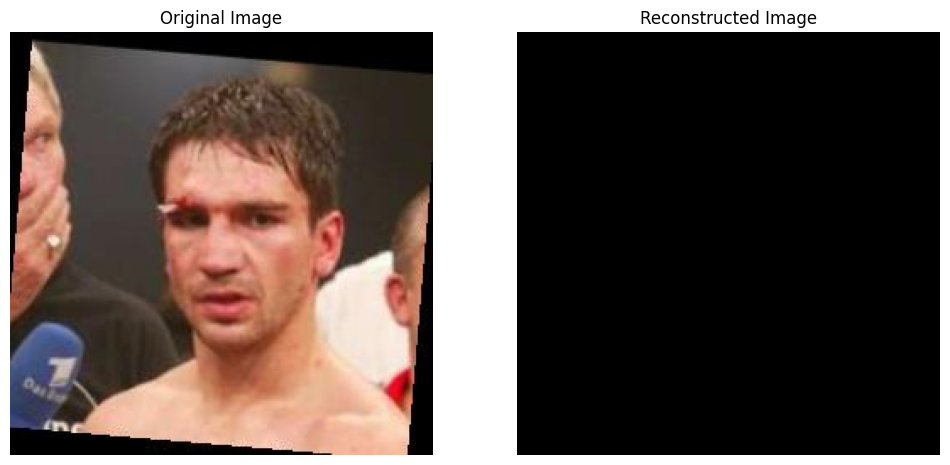

In [19]:
# Visualizing an original and a reconstructed image
images, _ = next(iter(dataloader))
original_image = images[0]

# Check the range of the original image to decide on normalization
print("Original image range:", original_image.min().item(), original_image.max().item())

# Normalize and flatten the image
# Normalize only if necessary
image_flattened = original_image.view(1, -1).to(device)  # Normalize here if required

# Pass the image through the VAE
with torch.no_grad():
    reconstructed_image, _, _ = model(image_flattened)
    reconstructed_image = reconstructed_image.view(3, image_height, image_width).cpu()

# Check the range of the reconstructed image
print("Reconstructed image range:", reconstructed_image.min().item(), reconstructed_image.max().item())

# Convert to numpy for plotting
original_image_np = original_image.permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.permute(1, 2, 0).numpy()

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np, cmap='gray' if num_channels == 1 else None)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()
